### Variables

- ts = timeseries dataset
- ts_clean = ts with negs replaced with NaN and rows with less than or = 4 non-Nans are dropped
- sdsc = StandardScaler
- ts_num = ts_clean with string vals dropped
- scale_num = scaled ts_num
- kmns = KMeans

In [2]:
import numpy as np
import pandas as pd

# ts = time series
ts = pd.read_csv("anes_timeseries_2024_csv_20250219.csv")



C:\Users\minod\AppData\Local\Temp\ipykernel_9848\1002808299.py:5: DtypeWarning: Columns (6,7,8,12,13,14,15,16,17,705,706) have mixed types. Specify dtype option on import or set low_memory=False.
  ts = pd.read_csv("anes_timeseries_2024_csv_20250219.csv")


In [3]:
# Clean up >0 values --> NaN

neg_to_nan = {i: np.nan for i in range(-99, 0)}

# replace all negs
ts_clean = ts.replace(neg_to_nan)

# dont need rows with too many NaNs
# remove row with >=4 Nans --> keep rows with 5+ nonNaN vals
# keep rest of rows
ts_clean = ts_clean.dropna(thresh=5)

#ts_clean.head()

In [4]:
# Scaling the dataset

from sklearn.preprocessing import StandardScaler as sdsc

# new
scaler = sdsc()

# string values still there (used scaler, didnt scale) --> removing strings
ts_num = ts_clean.select_dtypes(float)
# fill NaNs with mean of each row
ts_num = ts_num.fillna(ts_num.mean())






# debug
ts_num.isnull().sum()
# scaling
#scale_num = scaler.fit_transform(ts_num)


V240105a       0
V241001        0
V241002        0
V241003        0
V241004        0
            ... 
V241618        0
V241619        0
V241620        0
V241621        0
V241622     3349
Length: 684, dtype: int64

In [5]:
ts_num.nunique()

V240105a    3273
V241001        3
V241002        3
V241003        3
V241004        6
            ... 
V241618        8
V241619        6
V241620        6
V241621        6
V241622        0
Length: 684, dtype: int64

In [6]:
# dropping columns (axis = 1) with NaN values
ts_num = ts_num.dropna(axis=1, how='any')


In [7]:
ts_num.nunique() > 1

V240105a    True
V241001     True
V241002     True
V241003     True
V241004     True
            ... 
V241617     True
V241618     True
V241619     True
V241620     True
V241621     True
Length: 555, dtype: bool

In [8]:
# keep good columns 
good_cols = ts_num.nunique()[ts_num.nunique() > 1].index

ts_num = ts_num[good_cols]

#ts_num.head()

#### Progress:

- removed all NaN columns
- replaced NaNs with mean of row
- dropped shitty columns

In [9]:
# SCALING FINALLY

scale_num = scaler.fit_transform(ts_num)

## Clustering - KMeans

In [10]:
from sklearn.cluster import KMeans as kmns

In [11]:
# TEST
# starting with k = 3

test_model = kmns(n_clusters = 3, random_state = 42)

# grouping model
train_model = test_model.fit_predict(scale_num)


In [12]:
# ^ train model is an array
# add that array as a new column into ts_num
ts_num["cluster"] = train_model

C:\Users\minod\AppData\Local\Temp\ipykernel_9848\516260197.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ts_num["cluster"] = train_model


In [13]:
# group by clusters --> 3 clusters
cluster_summ = ts_num.groupby("cluster").mean()

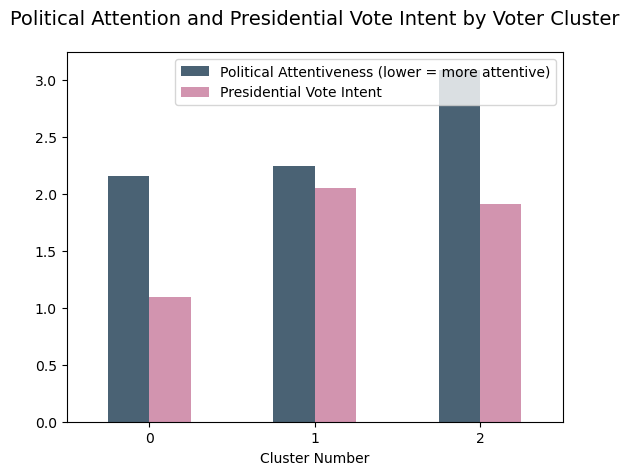

<Figure size 640x480 with 0 Axes>

In [83]:
import matplotlib.pyplot as plt

# plotting 2 clusters

# V241004 = political attention --> lower = more attentive, higher = less attentive
#V241043 = intended presidential vote --> 1=Harris, 2=Trump, 5=other


cluster_summ.rename(columns={
    "V241004": "Political Attentiveness (lower = more attentive)",
    "V241043": "Presidential Vote Intent"
})[["Political Attentiveness (lower = more attentive)", "Presidential Vote Intent"]].plot(kind="bar", color=["#4a6274","#d294af"])
plt.xlabel("Cluster Number")
plt.xticks(rotation = 0)
plt.title("Political Attention and Presidential Vote Intent by Voter Cluster", pad=20, fontsize=14)
plt.show()
plt.savefig("political_attention_pres_vote.png")

# Output
# pol attention - cluster 0 --> highest, cluster 1 --> mid, 2 --> lowest
# presidential vote - cluster 0 --> harris leaning, 1 --> trump leaning, 3 --> trump leaning + unsure

## Meaning of chart

### cluster 0 = most politically attentive, Harris-leaning
### cluster 1 = mid politically attentive, Trump-leaning
### cluster 2 = lowest political attention, unknown/Trump-leaning

In [16]:
# by demographics --> man/woman --> V241003
# 1 = man, 2 = woman
ts_num.groupby(["cluster", "V241003"]).size()

cluster  V241003
0        1.000      168
         1.525      753
         2.000      216
1        1.000      170
         1.525      634
         2.000      117
2        1.000      156
         1.525      922
         2.000      213
dtype: int64

In [17]:
# raw gender count per cluster
# 1.525 --> unknown cause NaN replaced with means

gender_counts = ts_num.groupby(["cluster", "V241003"]).size().unstack()

gender_counts

V241003,1.000,1.525,2.000
cluster,,,
0,168,753,216
1,170,634,117
2,156,922,213


In [18]:
# gender as percentages in each cluster
# 1 = man, 2 = woman, 1.525 = unknown/imputated

gender_percent = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100

gender_percent

V241003,1.000,1.525,2.000
cluster,,,
0,14.775726,66.226913,18.997361
1,18.458198,68.838219,12.703583
2,12.083656,71.417506,16.498838


In [19]:
# rename numbers to gender
gender_percent = gender_percent.rename(columns={1.0: "Men", 1.525: "Unknown", 2.0: "Women"})

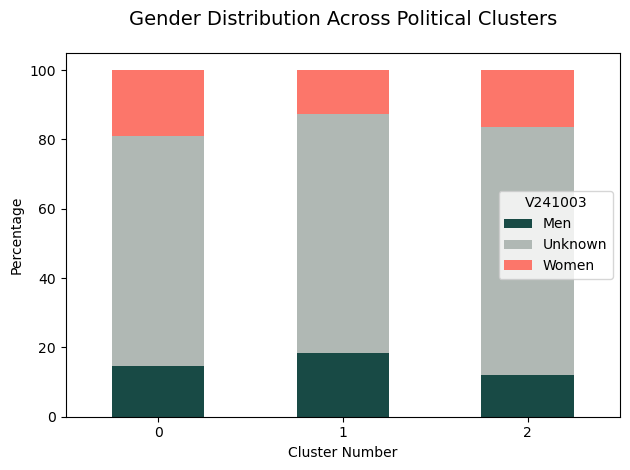

<Figure size 640x480 with 0 Axes>

In [84]:
# Plot
gender_percent.plot(kind='bar', stacked=True, color=["#184a45ff", "#b0b8b4ff", "#fc766aff"])
plt.xlabel("Cluster Number")
plt.xticks(rotation = 0)
plt.ylabel("Percentage")
plt.title("Gender Distribution Across Political Clusters", pad=20, fontsize=14)
plt.tight_layout()
plt.show()
plt.savefig("gender_distr.png")

#### Var = V241017a - Race 
- 1 = white
- 2 = black
- 3 = hispanic
- 4 = asian
- 5 = mixed/other

In [21]:
#ts_num.groupby(["cluster", "V241017a"]).size().unstack()

#age_data = ts_clean.copy()
#age_data["cluster"] = ts_num["cluster"]
#age_data.groupby(["cluster", "V241017a"]).size().unstack()

In [22]:
race_data = pd.read_csv("anes_timeseries_2024_csv_20250219.csv", usecols=["V241017"])
race_data["cluster"] = ts_num["cluster"]


In [23]:
#import pandas as pd

#Load just the column names from the original file
#cols = pd.read_csv("anes_timeseries_2024_csv_20250219.csv", nrows=0).columns.tolist()
#cols


In [60]:
race_data = pd.read_csv("anes_timeseries_2024_csv_20250219.csv", usecols=["V241501x"])
race_data["cluster"] = ts_num["cluster"]


In [61]:
race_counts = race_data.groupby(["cluster", "V241501x"]).size().unstack()

In [62]:
race_counts

V241501x,-9,-8,-4,1,2,3,4,5,6
cluster,,,,,,,,,
0,5.0,NaN,1.0,818.0,130.0,108.0,40.0,2.0,33.0
1,16.0,NaN,1.0,792.0,9.0,52.0,15.0,6.0,30.0
2,23.0,1.0,NaN,691.0,192.0,227.0,70.0,19.0,68.0


In [63]:
# convert to %s

race_percent = race_counts.div(race_counts.sum(axis=1), axis=0) * 100

race_percent

V241501x,-9,-8,-4,1,2,3,4,5,6
cluster,,,,,,,,,
0,0.439754,NaN,0.087951,71.943712,11.433597,9.498681,3.518030,0.175901,2.902375
1,1.737242,NaN,0.108578,85.993485,0.977199,5.646037,1.628664,0.651466,3.257329
2,1.781565,0.077459,NaN,53.524400,14.872192,17.583269,5.422153,1.471727,5.267235


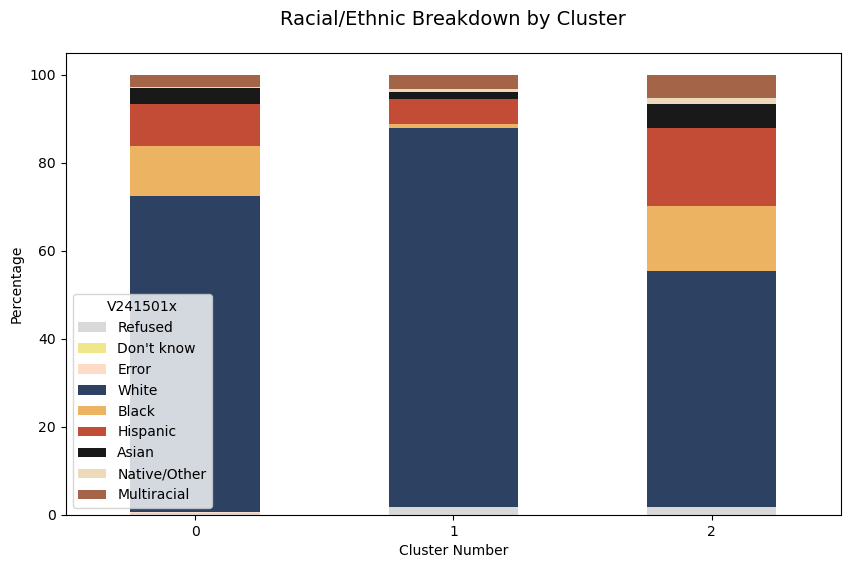

In [87]:
# rename codes
race_percent = race_percent.rename(columns={
    -9: "Refused",
    -8: "Don't know",
    -4: "Error",
    1: "White",
    2: "Black",
    3: "Hispanic",
    4: "Asian",
    5: "Native/Other",
    6: "Multiracial"
})

# plot
race_percent.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10,6), 
    color=[
    "#d9d9d9",  # Refused (light gray)
    "#f0e68c",  # Don't know (khaki)
    "#fddbc7",  # Error (pale coral)
    "#2d4263",  # White (yellow)
    "#ecb362",  # Black (dark blue)
    "#c34c36",  # Hispanic (dark red)
    "#191919",  # Asian ()
    "#ecdabb",  # Native/Other (deep purple)
    "#a36447"   # Multiracial ()
    ])
plt.title("Racial/Ethnic Breakdown by Cluster", pad=20, fontsize=14)
plt.xticks(rotation=0)
plt.xlabel("Cluster Number")
plt.ylabel("Percentage")
plt.savefig("race_breakdown.png")

#### Cluster 2 stands out for its racial diversity, with a significantly higher share of Hispanic, Black, and Multiracial respondents. Cluster 1, by contrast, is predominantly White, suggesting a strong demographic divide across clusters.

## Employment Status

"V241489a" → Homemaker

"V241489b" → Retired

"V241489c" → Permanently disabled

"V241489d" → Full-time student

"V241489e" → None of the above

1 --> mentioned
2---> not mentioned

In [52]:
# load relevant employment columns
empl_data = pd.read_csv("anes_timeseries_2024_csv_20250219.csv", usecols=["V241489a", "V241489b", "V241489c", "V241489d", "V241489e"])

# attach cluster
empl_data["cluster"] = ts_num["cluster"]


In [54]:
# % of each cluster with 1 as answer to each empl status

empl_count = empl_data.groupby(["cluster"])
empl_count_perc = empl_count.mean() * 100

empl_count_perc

,V241489a,V241489b,V241489c,V241489d,V241489e
cluster,,,,,
0,10.378188,31.750220,2.902375,2.462621,49.252419
1,13.680782,33.659066,3.908795,-0.108578,44.625407
2,8.597986,4.725019,0.697134,-0.077459,55.538342


In [55]:
# rename cols

empl_count_perc = empl_count_perc.rename(columns={"V241489a": "Homemaker", "V241489b": "Retired", "V241489c": "Permanently Disabled", "V241489d": "Full-time Student", "V241489e": "None of the Above"})

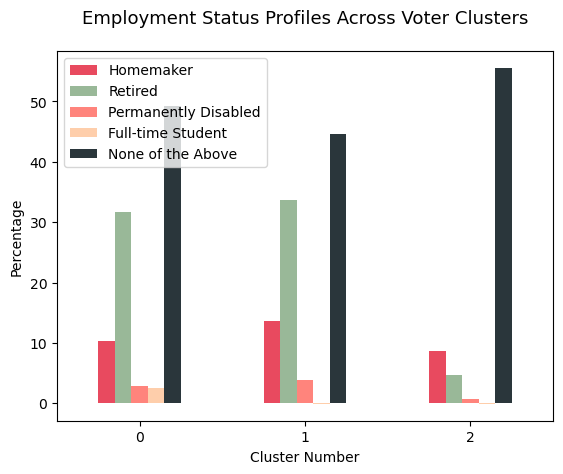

<Figure size 640x480 with 0 Axes>

In [90]:
# plot

empl_count_perc.plot(
    kind='bar',
    color=[
    "#e84a5f",
    "#99b898",
    "#ff847c",
    "#feceab",
    "#2a363b"
    ])
plt.xticks(rotation=0)
plt.xlabel("Cluster Number")
plt.ylabel("Percentage")
plt.title("Employment Status Profiles Across Voter Clusters", pad=20, fontsize=13)
plt.show()
plt.savefig("employment_breakdown.png")

## Meaning of chart

### cluster 0
####    - Harris-leaning, most political attention
####    - mid # of homemakers, retirees, disabled, one of the above (or employed)
####    - highest # of full-time students

### cluster 1
####    - Trump-leaning, mid political attention
####    - highest # of homemakers, retirees, disabled
####    - lowest # of full-time students, none of the above (or employed)

### cluster 2
#### - Unknown/Trump-leaning, lowest political attention
#### - highest # of none of the above (or employed)
#### - lowest # of homemakers, retired, disabled, full-time students
#### 